<a href="https://colab.research.google.com/github/chiragtyagi2003/Reinforcement-Learning/blob/main/RL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

# Download and import the MIT 6.S191 package
!printf "Installing MIT deep learning package... "
!pip install --upgrade git+https://github.com/aamini/introtodeeplearning.git &> /dev/null
!echo "Done"

Installing MIT deep learning package... Done


In [3]:
#Install some dependencies for visualizing the agents
!apt-get install -y xvfb python-opengl x11-utils &> /dev/null
!pip install gym pyvirtualdisplay scikit-video ffio pyrender &> /dev/null
!pip install tensorflow_probability==0.12.0 &> /dev/null
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import numpy as np
import matplotlib, cv2
import matplotlib.pyplot as plt
import base64, io, os, time, gym
import IPython, functools
import time
from tqdm import tqdm
import tensorflow_probability as tfp

import mitdeeplearning as mdl

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:61: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/internal/backend/numpy/dtype.py:82: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bool = np.bool  # pylint: disable=redefined-builtin
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/internal/backend/numpy/dtype.py:112: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# instantiate the cartpole environment

env = gym.make("CartPole-v1")
# set a seed to ensure thata the env's random
# variables are initialized the same each time
env.seed(1)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[1]

In [5]:
# getting the size of env observation space
n_observations = env.observation_space
print("Environment has observation space = ", n_observations)

Environment has observation space =  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [6]:
# getting the size of action space
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from = ", n_actions)

Number of possible actions that the agent can choose from =  2


In [7]:
# Define the Cartpole agent

### define a feed_forward neural network ###
def create_cartpole_model():
  model = tf.keras.models.Sequential([
      # first dense layer
      tf.keras.layers.Dense(units=32, activation = 'relu'),

      # last dense layer
      # units = 2 as action space = 2
      tf.keras.layers.Dense(units=n_actions, activation = None)
  ])

  return model

In [8]:
# define the agent's action fucntion

# function takes obs as input, executes a forward pass and outputs a sampled function
# arguments:
  # model => the network that defines the agent
  # obs => obs(s) which is/are fed to the network
  # single => flaf to as whether we are handling a single obs or a batch of obs, provided as np.array

# returns:
  # action => choice of agent action

def choose_action(model, observation, single=True):

  # add a batch dim, if only a single obs was provided
  observation = np.expand_dims(observation, axis=0) if single else observation

  # feed the observations through the model to
  # predict the log probabilities of each action
  logits = model.predict(observation)

  # choose an (1) action from the categorical distribution defined by
  # the log probabilities of each action
  action = tf.random.categorical(logits, num_samples=1)

  action = action.numpy().flatten()

  return action[0] if single else action


In [9]:
# Agent Memory

class Memory:

  def __init__(self):
    self.clear()

  # resets/restarts the memory buffer
  def clear(self):
    self.observations = []
    self.actions = []
    self.rewards = []

  # add obs, actions and rewards to memory
  def add_to_memory(self, new_observation, new_action, new_reward):

    self.observations.append(new_observation)

    self.actions.append(new_action)

    self.rewards.append(new_reward)


  def __len__(self):
    return len(self.actions)


# instantiate a single memory buffer
memory = Memory()

In [10]:
# reward function

# helper function to normalize an np.array x
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x.astype(np.float32)

# compute normalized, discounted, cumulative rewards(i.e return)
# args:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted rewards

def discount_rewards(rewards, gamma = 0.95):
  discounted_rewards = np.zeros_like(rewards)
  R = 0

  # why are calculating from the last reward?
  for t in reversed(range(0,len(rewards))):

    # update the total discounted reward
    R = R * gamma + rewards[t]
    discounted_rewards[t] = R

  return normalize(discounted_rewards)


In [11]:
# loss function

# args
#   logits: network's predictions for actions to take
#   actions: the actions the agent took in an episode
#   rewards: the rewards the agents received in an episode

#  Returns
#   loss

def compute_loss(logits, actions, rewards):

  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = actions)

  # scale the negative log probability by the reward
  loss = tf.reduce_mean( neg_logprob * rewards)

  return loss

In [12]:
# train step(Forward and backpropogation)

def train_step(model, loss_function, optimizer, observations,
               actions, discounted_rewards, custom_fwd_fn=None):

  with tf.GradientTape() as tape:

    # forward propogate through the agent network
    if custom_fwd_fn is not None:
      prection = custom_fwd_fn(observations)

    else:
      prediction = model(observations)


    loss = loss_function(prediction, actions, discounted_rewards)

    # run teh backpropogation to minimize the loss
    grads = tape.gradient(loss, model.trainable_variables)

    grads, _ = tf.clip_by_global_norm(grads, 2)

    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [13]:
# training parameters

learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate)

cartpole_model = create_cartpole_model()


# to track our progress

# its a kind of list
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.95)

plotter = mdl.util.PeriodicPlotter(sec=2, xlabel = "Iterations", ylabel = "Rewards")




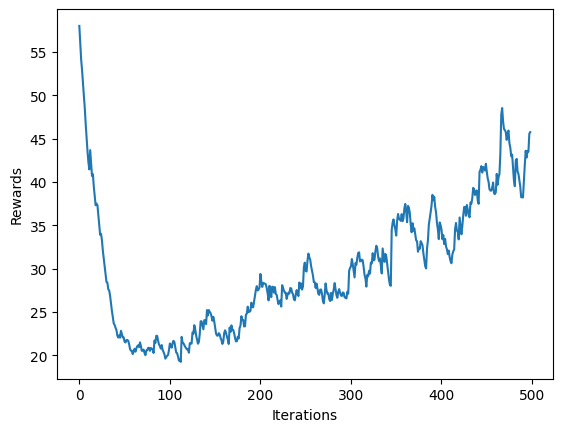

1/1 [==============================] - 0s 43ms/step


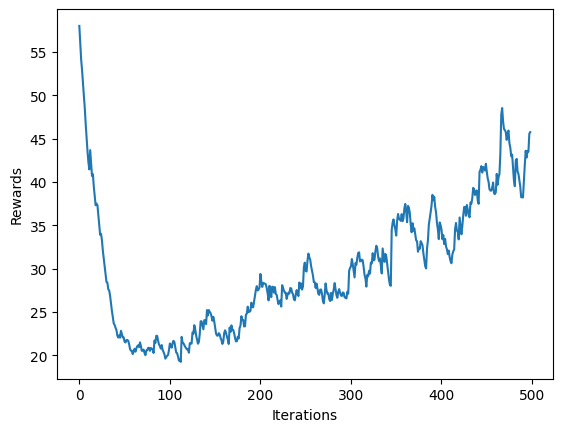

In [14]:
# cartpole training

if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for i_episode in range(500):

  plotter.plot(smoothed_reward.get())

  # restart the env
  observation = env.reset()
  memory.clear()

  while True:

    # using our obs, choose an action and take a step
    action = choose_action(cartpole_model, observation)


    # default param are returned
    next_observation, reward, done, info = env.step(action)

    # add to memory
    memory.add_to_memory(observation, action, reward)

    # is the episode over?
    if done:

      # determine the total reward and keep a recod of this
      total_reward = sum(memory.rewards)

      smoothed_reward.append(total_reward)

      # initiate training
      g = train_step(cartpole_model, compute_loss, optimizer,
                     observations = np.vstack(memory.observations),
                     actions = np.array(memory.actions),
                     discounted_rewards = discount_rewards(memory.rewards),
                     )

      # reset the memory
      memory.clear()
      break

    # update the observations
    observation = next_observation

In [30]:
from IPython.display import HTML
import io
import base64

def play_video(filename, width=None):
    encoded = base64.b64encode(io.open(filename, 'r+b').read())
    video_width = 'width="' + str(width) + '"' if width is not None else ''
    embedded = HTML(data='''
        <video controls {0}>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>'''.format(video_width, encoded.decode('ascii')))

    return embedded


In [31]:
def preprocess_pong(image):
    I = image[35:195] # Crop
    I = I[::2, ::2, 0] # Downsample width and height by a factor of 2
    I[I == 144] = 0 # Remove background type 1
    I[I == 109] = 0 # Remove background type 2
    I[I != 0] = 1 # Set remaining elements (paddles, ball, etc.) to 1
    I = cv2.dilate(I, np.ones((3, 3), np.uint8), iterations=1)
    I = I[::2, ::2, np.newaxis]
    return I.astype(np.float)

def pong_change(prev, curr):
    prev = preprocess_pong(prev)
    curr = preprocess_pong(curr)
    I = prev - curr
    # I = (I - I.min()) / (I.max() - I.min() + 1e-10)
    return I

In [34]:
def save_video_of_model(model, env_name, suffix=""):
    import gym
    import numpy as np
    import skvideo.io

    env = gym.make(env_name)
    obs = env.reset()

    filename = env_name + suffix + ".mp4"
    output_video = skvideo.io.FFmpegWriter(filename)

    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        output_video.writeFrame(frame)

        action = model.predict(np.expand_dims(obs, 0)).argmax()

        obs, reward, done, info = env.step(action)

    output_video.close()
    print("Successfully saved video as: {}".format(filename))
    return filename

# Make sure to replace 'cartpole_model' and 'CartPole-v1' with your actual model and environment
saved_cartpole = save_video_of_model(cartpole_model, "CartPole-v1")


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/skvideo/io/abstract.py:514: DeprecationWarning: tostring() is deprecated. Use toby

1/1 [==============================] - 0s 23ms/step
Successfully saved video as: CartPole-v1.mp4


In [35]:
matplotlib.use("Agg")
# saved_cartpole = save_video_of_model(cartpole_model, "CartPole-v1")
play_video(saved_cartpole)